In [1]:
%matplotlib inline

import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

# Carbon Impulse Response Function (i.e. the baseline curve)

This section models two Impulse Reponse Functions (IRFs). An IRF represents the time-dependent fraction of an  emission pulse remaining in the atmosphere at time t. It is convenient to describe the IRF for a particular gas X by exponential functions:

$ IRF_x(t) = a_{x,0} + \sum_{i=1}^{3} a_{x,i} * e^{-t / tau_i} $

The $a$ and $tau$ parameters for CO2 can be taken from literature: 

- Joos, F., Roth, R., Fuglestvedt, J. S., Peters, G. P., Enting, I. G., von Bloh, W., Brovkin, V., Burke, E. J., Eby, M., Edwards, N. R., Friedrich, T., Frölicher, T. L., Halloran, P. R., Holden, P. B., Jones, C., Kleinen, T., Mackenzie, F. T., Matsumoto, K., Meinshausen, M., Plattner, G.-K., Reisinger, A., Segschneider, J., Shaffer, G., Steinacher, M., Strassmann, K., Tanaka, K., Timmermann, A., and Weaver, A. J.: Carbon dioxide and climate impulse response functions for the computation of greenhouse gas metrics: a multi-model analysis, Atmos. Chem. Phys., 13, 2793–2825, https://doi.org/10.5194/acp-13-2793-2013, 2013.

- Forster, P., V. Ramaswamy, P. Artaxo, T. Berntsen, R. Betts, D.W. Fahey, J. Haywood, J. Lean, D.C. Lowe, G. Myhre, J. Nganga, R. Prinn, G. Raga, M. Schulz and R. Van Dorland, 2007: Changes in Atmospheric Constituents and in Radiative Forcing. In: Climate Change 2007: The Physical Science Basis. Contribution of Working Group I to the Fourth Assessment Report of the Intergovernmental Panel on Climate Change [Solomon, S., D. Qin, M. Manning, Z. Chen, M. Marquis, K.B. Averyt, M.Tignor and H.L. Miller (eds.)]: https://www.ipcc.ch/site/assets/uploads/2018/02/ar4-wg1-chapter2-1.pdf (pg. 213)

- IPCC: Special Report on Land Use, Land‐Use Change, and Forestry, Section 2.3.6.3, 2000, https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74 and footnote https://archive.ipcc.ch/ipccreports/sres/land_use/fn3.htm#4


In [2]:
def IRF(t_horizon, curve):
    
    if curve == 'joos_2013':
        # parameters from Joos et al, 2013 (Table 5)
        a = [0.2173, 0.2240, 0.2824, 0.2763]
        tau = [0, 394.4, 36.54, 4.304]
    elif curve == 'ipcc_2007':
        # parameters from IPCC 2007 (page 213)
        a = [0.217, 0.259, 0.338, 0.186]
        tau = [0, 172.9, 18.51, 1.186]
    elif curve == 'ipcc_2000':
        # parameters from IPCC Special Report 2000, Ch2, Footnote 4
        a = [0.175602, 0.137467, 0.18576, 0.242302, 0.258868]
        tau = [0, 421.093, 70.5965, 21.42165, 3.41537]

    IRF = [a[0]] * len(t_horizon)
    for t in t_horizon:
        for i in np.arange(1,len(a)):
            IRF[t] =  IRF[t] + (a[i] * np.exp(-t/tau[i]))
    
    return IRF

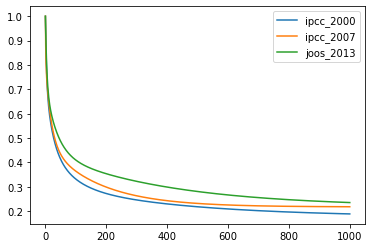

In [3]:
t_horizon = np.arange(1001)
ipcc_2000 = IRF(t_horizon, 'ipcc_2000')
ipcc_2007 = IRF(t_horizon, 'ipcc_2007')
joos_2013 = IRF(t_horizon, 'joos_2013')
plt.plot(t_horizon, ipcc_2000, label='ipcc_2000')
plt.plot(t_horizon, ipcc_2007, label='ipcc_2007')
plt.plot(t_horizon, joos_2013, label='joos_2013')
plt.legend()

Joos et al. (2013) report the following time-dependent fractions of an original pulse of CO2 remaining in the atmosphere in their results, section 4.1: 
- 0.6 +- 0.14 at year 20
- 0.4 +- 0.13 at year 100
- 0.25 +- 0.09 at year 1000

We can compare that to the joos_2013 curve we generated above: 

In [4]:
for curve in [joos_2013]:
    print('At t=20:   '+ str(round(curve[20],3)))
    print('At t=100:  '+ str(round(curve[100],3)))
    print('At t=1000: '+ str(round(curve[-1],3)))
    print()

At t=20:   0.596
At t=100:  0.409
At t=1000: 0.235



--> **Flag: what's going on at t=1000?** <--

# Ton-year accounting methods

Some terms for interpreting the three ton-year accounting methods implemented below

- *Baseline:* the curve atmospheric state-of affairs that is assumed to be the counterfaction to a project scenario
- *Baseline atmospheric impact:* the integral of the baseline curve
- *Scenario:* the curve representing what happens because of an intervention (could be representing carbon in a stock or carbon in the atmosphere depending on the method)
- *Benefit:* the reduction in atmospheric impact as a result of the scenario intervention 
- *Equivalence factor:* the ratio between the benefit and the atmospheric impact of a single tCO2 released at t=0 under shared assumptions


Some helper functions:

In [5]:
def discount(discount_rate, curve): 
    return [x/math.pow(1+discount_rate, i) for i,x in enumerate(curve)]

In [259]:
def print_benefit_report(method_output, plot):
    print()
    print('Discount rate: ' + str(round(method_output['discount_rate']*100,1)) + '%')
    print('Delay: ' + str(method_output['delay']) + ' year(s)')
    print('Baseline atmospheric cost: ' + str(round(method_output['baseline_atm_impact'],2)) + ' ton-years')
    print('Benefit from 1tCO2 with delay: ' + str(round(method_output['benefit'],2)) + ' ton-years')
    print('Number needed: ' + str(round(method_output['num_needed'],1)))
    print()
    if plot: 
        plot = plt.plot(method_output['baseline'], label="baseline")
        plot = plt.plot(method_output['scenario'], label="scenario")
        plot = plt.legend()

And a function implementing the three ton-year accounting set-ups:

In [141]:
def get_tonyear_setup(method, time_horizon, baseline, delay, discount_rate):
    baseline = baseline[0:time_horizon+1]
    baseline_discounted = discount(discount_rate, baseline)
    baseline_atm_impact = np.trapz(baseline_discounted)
    
    if method == 'mc':
        t = np.arange(time_horizon+1)
        scenario = [-1]*(delay+1) + [0]*(time_horizon-delay)   
        scenario = discount(discount_rate, scenario)
        benefit = -np.trapz(scenario[:delay+1])
    elif method == 'ipcc':
        t = np.arange(time_horizon+1)
        scenario = [0]*delay + baseline
        scenario = scenario[0:time_horizon+1]
        if time_horizon < delay:
            scenario = scenario[:time_horizon+1]
        scenario = discount(discount_rate, scenario)
        benefit = baseline_atm_impact - np.trapz(scenario[delay:])
    elif method == 'lashof':
        t = np.arange(time_horizon + delay + 1)
        scenario = [0]* delay + baseline
        scenario = discount(discount_rate, scenario)
        benefit = np.trapz(scenario[time_horizon:])
    else: 
        print('No method by that name.')
        return None
        
    return {'method': method,
            't': t,
            'delay': delay,
            'discount_rate': discount_rate,
            'scenario': scenario,
            'baseline': baseline_discounted,
            'baseline_atm_impact': baseline_atm_impact,
            'benefit': benefit,
            'num_needed': baseline_atm_impact/benefit}

### Moura-Costa method

Method referenced IPCC Special report (2000) with outputs to check against: https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

Method also described in Moura Costa and Wilson, 2000: https://oxfordclimatepolicy.org/sites/default/files/10.1023%252FA_1009697625521.pdf


Discount rate: 0.0%
Delay: 46 year(s)
Baseline atmospheric cost: 45.76 ton-years
Benefit from 1tCO2 with delay: 46.0 ton-years
Number needed: 1.0



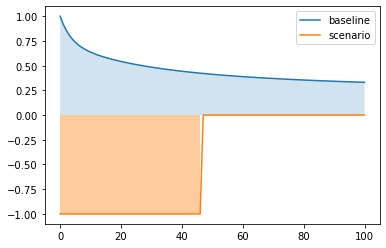

In [260]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
discount_rate = 0.0

m = get_tonyear_setup('mc', time_horizon, baseline, delay, discount_rate)
print_benefit_report(m, plot=True)
plot = plt.fill_between(m['t'], m['baseline'], alpha = 0.2)
plot = plt.fill_between(m['t'], m['scenario'], where=(np.array(m['scenario'])<0), alpha = 0.4)

Baseline = 1 tCO2 atmospheric carbon released at t=0 <br/>
Scenario = 1 tCO2 stored outside of the atmosphere for delay<br/>
Baseline atmospheric cost = (blue area) <br/>
Benefit = (orange area) <br/>
Number needed = how many orange areas are equivalent to the blue area? <br/>
** Assumes 0% re-emission ** <br/>
** Additionality double-bind **

### IPCC method 

Method described IPCC Special report, 2000: https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

Conceptually distinct but numerically identical to Lashof method when discount_rate = 0


Discount rate: 0.0%
Delay: 46 year(s)
Baseline atmospheric cost: 45.76 ton-years
Benefit from 1tCO2 with delay: 16.64 ton-years
Number tCO2 with delay needed: 2.8



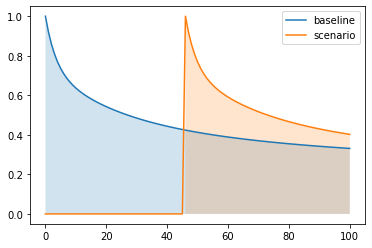

In [229]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
discount_rate = 0.0

i = get_tonyear_setup('ipcc', time_horizon, baseline, delay, discount_rate)
print_benefit_report(i, plot=True)
plot = plt.fill_between(i['t'], i['baseline'], alpha=0.2) 
plot = plt.fill_between(i['t'], i['scenario'], where=(i['t']>=i['delay']), alpha=0.2) 

Baseline = 1 tCO2 released into atmospheric at t=0 <br/>
Scenario = 1 tCO2 released into atomosphere with delay <br/>
Baseline atmospheric cost = (blue area) <br/>
Benefit = (blue area) - (orange area) <br/>
Number needed = how would you need to scale the "benefit" to equal to the blue area? <br/>
** Assumes 100% re-emission **

### Lashof method

Method referenced IPCC Special report, 2000: https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

And described in Fearnside, Lashof & Moura-Costa, 2000: https://link.springer.com/article/10.1023%2FA%3A1009625122628

Conceptually distinct but numerically identical to IPCC method when discount_rate = 0


Discount rate: 0.0%
Delay: 46 year(s)
Baseline atmospheric cost: 45.76 ton-years
Benefit from 1tCO2 with delay: 16.64 ton-years
Number tCO2 with delay needed: 2.8



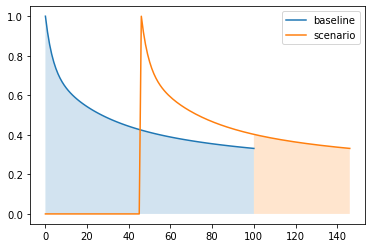

In [167]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
discount_rate = 0.0

l = get_tonyear_setup('lashof', time_horizon, baseline, delay, discount_rate)
print_benefit_report(l, plot=True)
plot = plt.fill_between(l['t'][:len(l['baseline'])], l['baseline'], alpha = 0.2)
plot = plt.fill_between(l['t'], l['scenario'], where=(l['t']>=time_horizon), alpha = 0.2)

Baseline = 1 tCO2 released into atmospheric at t=0 <br/>
Scenario = 1 tCO2 released into atomosphere with delay <br/>
Baseline atmospheric cost = (blue area)
Benefit = (orange area) = atmospheric cost no longer occuring w/in the time horizon <br/>
Number needed = how many orange areas would you need to equal the blue area?<br/>
** Assumes 100% re-emission **

# Methods x Delay

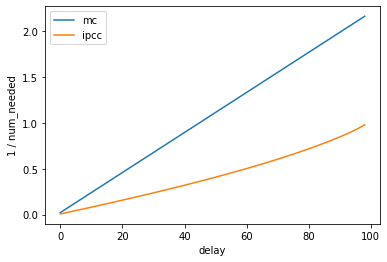

In [254]:
time_horizon = 100
baseline = ipcc_2000
#delay = 1
discount_rate = 0.0

for method in ['mc', 'ipcc']:
    num_needed = []
    for delay in np.arange(1,100):
        num_needed.append(1/get_tonyear_setup(method,time_horizon, baseline, delay, discount_rate)['num_needed'])
    plt.plot(num_needed, label=method)

plt.xlabel('delay')
plt.ylabel('1 / num_needed')
plt.legend()

# Methods x Time Horizon

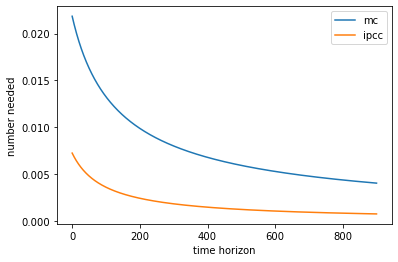

In [250]:
#time_horizon = 100
baseline = ipcc_2000
delay = 1
discount_rate = 0.0

for method in ['mc','ipcc']:
    num_needed = []
    for time_horizon in np.arange(100,1000):
        num_needed.append(1/get_tonyear_setup(method,time_horizon, baseline, delay, discount_rate)['num_needed'])
    plt.plot(num_needed,label=method)

plt.xlabel('time horizon')
plt.ylabel('number needed')
plt.legend()

# Methods x Discounting

Lashof excluded in the graph below as it is highly sensitive to discounting and blows up as discount rate increases

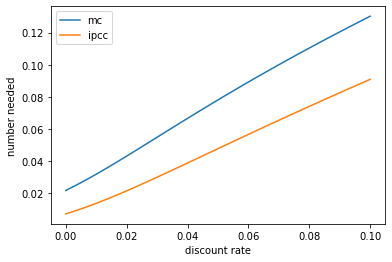

In [256]:
time_horizon = 100
baseline = ipcc_2000
delay = 1
#discount_rate = 0.0

d = np.linspace(0, 0.1, 30)
for method in ['mc','ipcc']:
    num_needed = []
    for discount_rate in d:
        num_needed.append(1/get_tonyear_setup(method,time_horizon, baseline, delay, discount_rate)['num_needed'])
    plt.plot(d, num_needed,label=method)

plt.xlabel('discount rate')
plt.ylabel('number needed')
plt.legend()


# Case Study: NCX 

Moura-costa method? 

- Time horizon: 100 years
- 1 tCO2e equivalency: 48 ton-years, citing IPCC 2007
- Discount rate: 3.3% → 17 ton-years today = 48 ton-years over 100 year

See "Forest and Carbon: A Guide for Buyers and Policymakers", p.21-24 for a description of the NCX ton-year accounting method: https://ncx.com/wp-content/uploads/2021/06/Forests-and-Carbon_A-Guide-for-Buyers-and-Policymakers_SilviaTerra2020_v0.4-2-1.pdf 

In [192]:
time_horizon = 100
baseline = ipcc_2007
delay = 1
discount_rate = 0.033

ncx = get_tonyear_setup('mc',time_horizon, baseline, delay, discount_rate)
print_benefit_report(ncx, plot=False)


Discount rate: 3.3%
Delay: 1 year(s)
Baseline atmospheric cost: 17.18 ton-years
Benefit from 1tCO2 with delay: 0.98 ton-years
Number tCO2 with delay needed: 17.5



If only cost is discounted (not the cost and benefit), then we replicate the ncx ratio of 17 to 1: 

In [193]:
discount_rate = 0
ncx_alt = get_tonyear_setup('mc',time_horizon, baseline, delay, discount_rate)

cost = ncx['baseline_atm_impact']
benefit = ncx_alt['benefit']

print('Baseline atmospheric impact: ' + str(round(cost,2)) + ' ton-years')
print('Delay: ' + str(ncx['delay']) + ' year(s)')
print('Benefit from delay: ' + str(round(benefit,2)) + ' ton-years')
print('Number needed: ' + str(round(cost/benefit,1)))

Baseline atmospheric impact: 17.18 ton-years
Delay: 1 year(s)
Benefit from delay: 1.0 ton-years
Number needed: 17.2


### Cost sensitivity

Imagine the cost carbon credit is $10/permanent ton, where a 'permanent ton' is a handful of ton-years packaged up according to the NCX methodology modeled above. We can then calculate the cost per ton-year:

In [194]:
ton_year_cost = 10/ncx['baseline_atm_impact']
round(ton_year_cost,2)

0.58


If the cost of a ton-year reflects a true cost of taking an action today, we can ask how the cost of a buying a 'permanent ton' via ton-years today changes as we change the method or parameters:

In [225]:
time_horizon = 1000
baseline = joos_2013
delay = 1
discount_rate = 0.00

ncx = get_tonyear_setup('ipcc', time_horizon, baseline, delay, discount_rate)
print_benefit_report(ncx, False)
print('Cost of permanent ton: $' + str(round(ton_year_cost * ncx['num_needed'],2)))


Discount rate: 0.0%
Delay: 1 year(s)
Baseline atmospheric cost: 310.16 ton-years
Benefit from 1tCO2 with delay: 0.24 ton-years
Number tCO2 with delay needed: 1319.4

Cost of permanent ton: $767.84
